In [3]:
import pandas as pd
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import SMOTENC

In [ ]:
X_train_raw = pd.read_csv('../data_splitted/X_train.csv') #'../processed/X_train_balanced.csv')
y_train_raw = pd.read_csv('../data_splitted/y_train.csv') #'../processed/y_train_balanced.csv')

In [ ]:
print(X_train.shape)
print(X_train.columns)
print(df_kmeans_segmented8.columns)


--- Decision Tree Segmentation ---


/home/aac/Anyone/FinalProject/CreditRiskAnalysisProject/data/modeling_data/segmented_model.py:69: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  X_train['dt_segment'] = dt_segmenter.apply(X_train) #.drop('kmeans_segment', axis=1, errors='ignore'))



Decision Tree segments distribution (Max leaf nodes aimed: 3):
dt_segment
1    38001
4    14961
3     6086
Name: count, dtype: int64

Target variable distribution within Decision Tree segments:
Segment 1:
target
1    0.542723
0    0.457277
Name: proportion, dtype: float64
--------------------
Segment 3:
target
1    0.571476
0    0.428524
Name: proportion, dtype: float64
--------------------
Segment 4:
target
0    0.637591
1    0.362409
Name: proportion, dtype: float64
--------------------


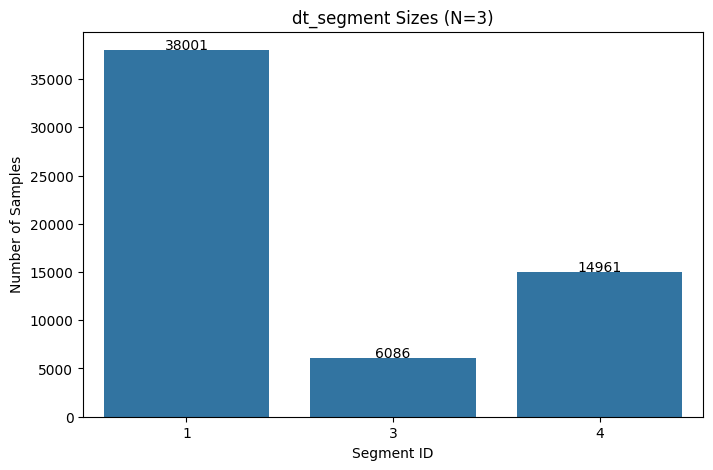

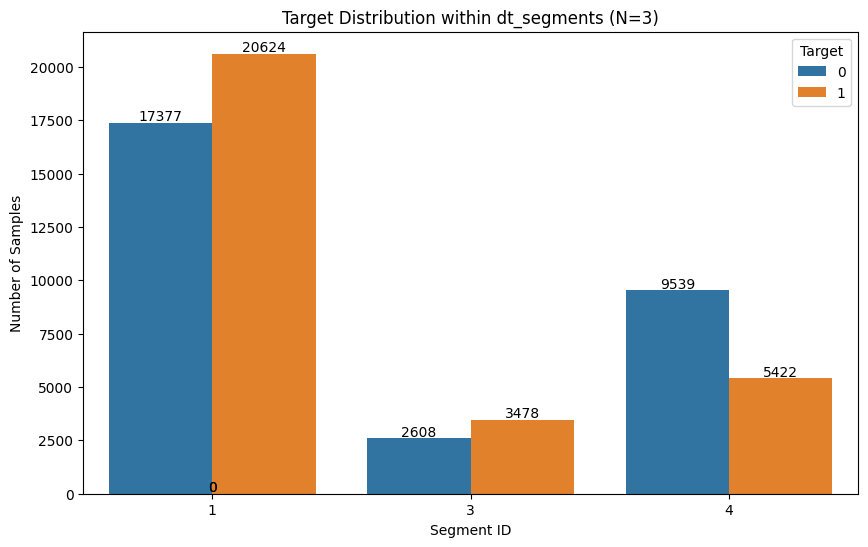

In [ ]:
dt_leafs = 3
df_dt_segmented3 = decision_trees_segmentation(dt_leafs, X_train, y_train)
visualize('dt_segment', X_train, df_dt_segmented3, dt_leafs) 

In [4]:
def apply_smote(X, y, random_state=42):
    """
    Applies SMOTE to balance the dataset.
    
    Args:
        X (pd.DataFrame): Features
        y (pd.Series or array): Target
        random_state (int): Seed for reproducibility
        
    Returns:
        X_resampled (pd.DataFrame), y_resampled (pd.Series)
    """
    
    sm = SMOTE(random_state=random_state)    # sampling_strategy=0.5)
    
    X_res, y_res = sm.fit_resample(X, y.values.ravel())
    X_resampled = pd.DataFrame(X_res, columns=X.columns)
    y_resampled = pd.Series(y_res, name="target")
    
    return X_resampled, y_resampled


def smotenc(X, y, categorical_features, random_state=42):
    """
    Applies SMOTENC to balance the dataset with categorical features.

    Args:
        X (pd.DataFrame): Features
        y (pd.Series or array): Target
        categorical_features (list): List of column indices (not names) that are categorical
        random_state (int): Seed for reproducibility

    Returns:
        X_resampled (pd.DataFrame), y_resampled (pd.Series)
    """
    sm = SMOTENC(categorical_features=categorical_features, random_state=random_state)

    X_res, y_res = sm.fit_resample(X.values, y.values.ravel())

    X_resampled = pd.DataFrame(X_res, columns=X.columns)
    y_resampled = pd.Series(y_res, name="target")

    return X_resampled, y_resampled

In [ ]:
import pandas as pd
import os

os.chdir("/home/aac/Anyone/FinalProject/CreditRiskAnalysisProject/")

X_train = pd.read_csv('data/processed/X_train_balanced.csv')

print(len(X_train))

print("¿Hay NaNs en X_train BALANCED?")
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    print(X_train.isnull().sum().to_string())

In [ ]:
y_train_balanced = pd.read_csv('data/processed/y_train_balanced.csv')

print(y_train_balanced.value_counts())

In [ ]:
X_train_balanced = pd.read_csv('data/processed/X_train_balanced.csv')

print(X_train_balanced.shape)

In [ ]:
def eda_by_segment(df_segmented):
    
    # Ensure the segment column exists
    if 'kmeans_segment' not in df_segmented.columns:
        raise ValueError("The DataFrame must contain a 'kmeans_segment' column.")
    
    # Identify numeric columns for statistics and plotting (excluding the segment column)
    # numeric_cols = df_segmented.select_dtypes(include='number').drop(columns=['kmeans_segment'], errors='ignore').columns

    segments = sorted(df_segmented['kmeans_segment'].unique())

    # Loop through each segment and perform EDA
    for segment_label in segments:
        segment_data = df_segmented[df_segmented['kmeans_segment'] == segment_label]
        
        print(f"\n=== EDA for Segment '{segment_label}' ===")
        print(f"Number of records: {segment_data.shape[0]}")
        print("\nDescriptive Statistics:")
        print(segment_data.describe())
        
        # Correlation heatmap
        plt.figure(figsize=(10, 6))
        sns.heatmap(segment_data.corr(), annot=True, cmap='coolwarm', fmt=".2f")
        plt.title(f'Correlation Heatmap - Segment {segment_label}')
        plt.tight_layout()
        plt.show()

        # Distribution plots for each numeric variable
        for col in df_segmented.columns:
            plt.figure(figsize=(6, 4))
            sns.histplot(segment_data[col], kde=True, bins=30)
            plt.title(f'Distribution of {col} - Segment {segment_label}')
            plt.xlabel(col)
            plt.ylabel('Frequency')
            plt.tight_layout()
            plt.show()
    
    return

In [ ]:
def calculate_segment_homogeneity(df, segment_col='dt_segment'):
    """
    Calcula la homogeneidad de los segmentos en un DataFrame.
    La homogeneidad se mide por la varianza para columnas numéricas
    y por la proporción de la moda para columnas categóricas.

    Args:
        df (pd.DataFrame): El DataFrame con los datos y la columna de segmento.
        segment_col (str): El nombre de la columna que indica el segmento.

    Returns:
        pd.DataFrame: Un DataFrame con la homogeneidad promedio para cada segmento
                      y la homogeneidad global del dataset.
    """
    if segment_col not in df.columns:
        raise ValueError(f"La columna de segmento '{segment_col}' no se encuentra en el DataFrame.")

    homogeneity_results = {}
    numerical_cols = df.select_dtypes(include=np.number).columns.drop(segment_col, errors='ignore')
    categorical_cols = df.select_dtypes(exclude=np.number).columns.drop(segment_col, errors='ignore')

    # Calcula la homogeneidad para cada segmento
    for segment_id in df[segment_col].unique():
        segment_df = df[df[segment_col] == segment_id]
        segment_homogeneity = {}

        # Homogeneidad para columnas numéricas (usando varianza)
        if not numerical_cols.empty:
            # Reemplazar NaN con la media del segmento para evitar que la varianza sea NaN
            for col in numerical_cols:
                if segment_df[col].isnull().any():
                    segment_df.loc[:, col] = segment_df[col].fillna(segment_df[col].mean())
            segment_homogeneity['numerical_variance_avg'] = segment_df[numerical_cols].var().mean()

        # Homogeneidad para columnas categóricas (usando proporción de la moda)
        if not categorical_cols.empty:
            mode_proportions = []
            for col in categorical_cols:
                if not segment_df[col].empty:
                    # Calcula la moda y su frecuencia
                    current_mode, current_count = mode(segment_df[col].dropna())
                    if len(current_mode) > 0: # Si se encuentra una moda
                        mode_proportion = current_count[0] / len(segment_df[col].dropna()) if len(segment_df[col].dropna()) > 0 else 0
                        mode_proportions.append(mode_proportion)
            if mode_proportions:
                segment_homogeneity['categorical_mode_proportion_avg'] = np.mean(mode_proportions)
            else:
                segment_homogeneity['categorical_mode_proportion_avg'] = np.nan # No hay columnas categóricas o están vacías

        homogeneity_results[f'Segment_{segment_id}'] = segment_homogeneity

    # Calcula la homogeneidad global del dataset (promedio ponderado por el tamaño del segmento)
    global_homogeneity = {'numerical_variance_global_avg': 0, 'categorical_mode_proportion_global_avg': 0}
    total_rows = len(df)
    
    for segment_id in df[segment_col].unique():
        segment_df = df[df[segment_col] == segment_id]
        segment_size = len(segment_df)
        weight = segment_size / total_rows
        
        segment_result = homogeneity_results[f'Segment_{segment_id}']
        
        if 'numerical_variance_avg' in segment_result and not pd.isna(segment_result['numerical_variance_avg']):
            global_homogeneity['numerical_variance_global_avg'] += segment_result['numerical_variance_avg'] * weight
        
        if 'categorical_mode_proportion_avg' in segment_result and not pd.isna(segment_result['categorical_mode_proportion_avg']):
            global_homogeneity['categorical_mode_proportion_global_avg'] += segment_result['categorical_mode_proportion_avg'] * weight

    results_df = pd.DataFrame(homogeneity_results).T
    
    # Agrega la fila de homogeneidad global
    global_homogeneity_series = pd.Series(global_homogeneity, name='Global_Homogeneity')
    results_df = pd.concat([results_df, pd.DataFrame([global_homogeneity_series])])

    return results_df


# --------

In [5]:
X_train = pd.read_csv('X_train_balanced.csv')
X_val = pd.read_csv('X_val_p.csv')
y_train = pd.read_csv('y_train_balanced.csv')
y_val = pd.read_csv('y_val.csv')

In [6]:
y_train.value_counts() #normalize=True)

TARGET_LABEL_BAD=1
0                     29524
1                     29524
Name: count, dtype: int64

In [9]:
smote = SMOTE(random_state=42, sampling_strategy=0.5)

# Aplicar SMOTE solo a los datos de entrenamiento
xtrain_balanceado, ytrain_balanceado = smote.fit_resample(X_train, y_train)

print("Dimensiones originales de ytrain:")
print(y_train.value_counts())
print("\nDimensiones de ytrain después de SMOTE:")
print(ytrain_balanceado.value_counts())

ValueError: The specified ratio required to remove samples from the minority class while trying to generate new samples. Please increase the ratio.

In [ ]:
import pandas as pd
import os

os.chdir("/home/aac/Anyone/FinalProject/CreditRiskAnalysisProject/")

X_train = pd.read_csv('data/processed/interim/X_train_X_train_unbalanced.csv')
X_val = pd.read_csv('data/processed/interim/X_val_X_val_unbalanced.csv')

print("¿Hay NaNs en X_train?")
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    print(X_train.isnull().sum().to_string())
    print("\n\n","-"*20)
    print("-- Now X_val --")
    print("\n")
    print(X_val.isnull().sum().to_string())
